# Autoencoder

## Libraries config

In [1]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from utils import plot_activations

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai
from fastai import train as tr


import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')


## Running enviroment

In [2]:
if torch.cuda.is_available():
    fastai.torch_core.defaults.device = 'cuda'
    print('GPU nviroment with the follow configuration')
    !nvidia-smi
else:
    fastai.torch_core.defaults.device = 'cpu'
    print('CPU enviroment with the follow configuration')
    !lscpu

GPU nviroment with the follow configuration
Tue Mar 24 16:46:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.57                 Driver Version: 410.57                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 29%   29C    P8    31W / 250W |   1918MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:3D:00.0 Off |                  N/A |
| 29%   28C    P8    30W / 250W |     10MiB / 10989MiB |      0%      Default |
+-------------------------------+-----------

## Data

In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle(BIN + 'processed_data/all_jets_test_4D_100_percent.pkl')

In [4]:
train.head(5)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


In [5]:
test.head(5)

,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


In [6]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

In [7]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [8]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [9]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [10]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f5600462dd8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f5600462eb8>;

Test: None

## Model

As the model is fine, I'm keep the structure for 4 variables as shown in the paper, but I-ve changed activation 

Default moldel is using Tanh but the paper reports there are better result using LeakyRelu, So in this reconstruction I'm using it

In [11]:
class AE_3D_200(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.lrelu = nn.LeakyReLU()

    def encode(self, x):
        x = self.lrelu(self.en1(x))
        x = self.lrelu(self.en2(x))
        x = self.lrelu(self.en3(x))
        x = self.en4(x)
        
        return x

    def decode(self, x):
        x=self.lrelu(x)
        x=self.lrelu(self.de1(x))
        x=self.lrelu(self.de2(x))
        x=self.lrelu(self.de3(x))
        x=self.de4(x)         
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'

In [12]:
model = AE_3D_200()
print(model)

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
)


In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

52607

In [14]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
loss_func = nn.MSELoss().float()
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func ,opt_func=optim.Adam, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [15]:

tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


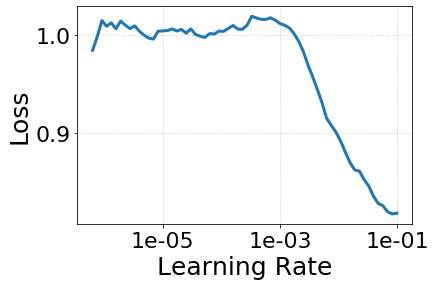

In [16]:
learn.recorder.plot()

### 1cycle policy

In [17]:
learn.fit(8,1e-2)

epoch,train_loss,valid_loss,time
0,0.026504,0.025904,00:06
1,0.023864,0.023900,00:07
2,0.021582,0.020324,00:06
3,0.020979,0.023322,00:07
4,0.019294,0.017029,00:07
5,0.018802,0.019242,00:08
6,0.024158,0.034374,00:07
7,0.015953,0.016473,00:06


In [18]:
learn.fit(10,1e-4)

epoch,train_loss,valid_loss,time
0,0.012625,0.012379,00:07
1,0.012327,0.011719,00:08
2,0.011675,0.011478,00:06
3,0.011643,0.011263,00:08
4,0.011659,0.011033,00:07
5,0.011182,0.010899,00:05
6,0.011044,0.010810,00:05
7,0.010623,0.010775,00:05
8,0.010142,0.010702,00:05
9,0.010677,0.010608,00:05


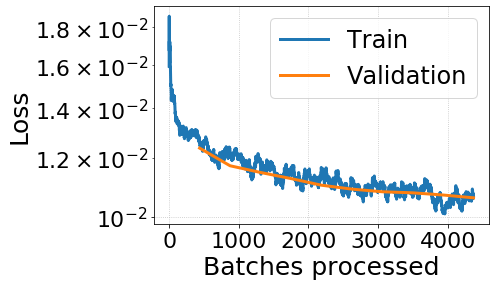

In [19]:
learn.recorder.plot_losses()
plt.yscale('log')

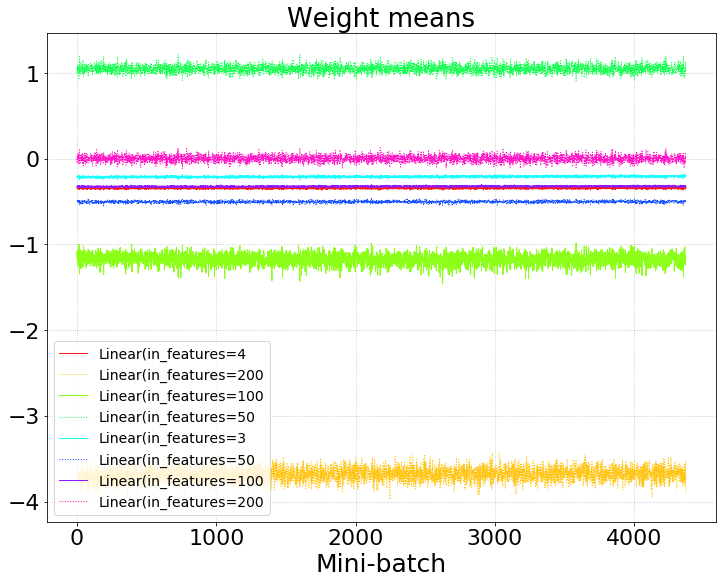

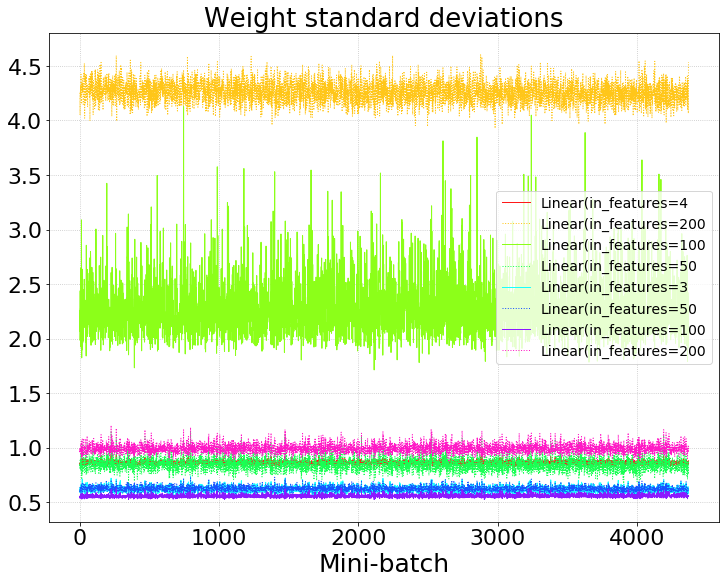

In [20]:
plot_activations(learn)


In [21]:
learn.validate()

[0.010608404]

In [22]:
model.to('cpu')

AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
)

In [23]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)
alph = 0.8
n_bins = 100


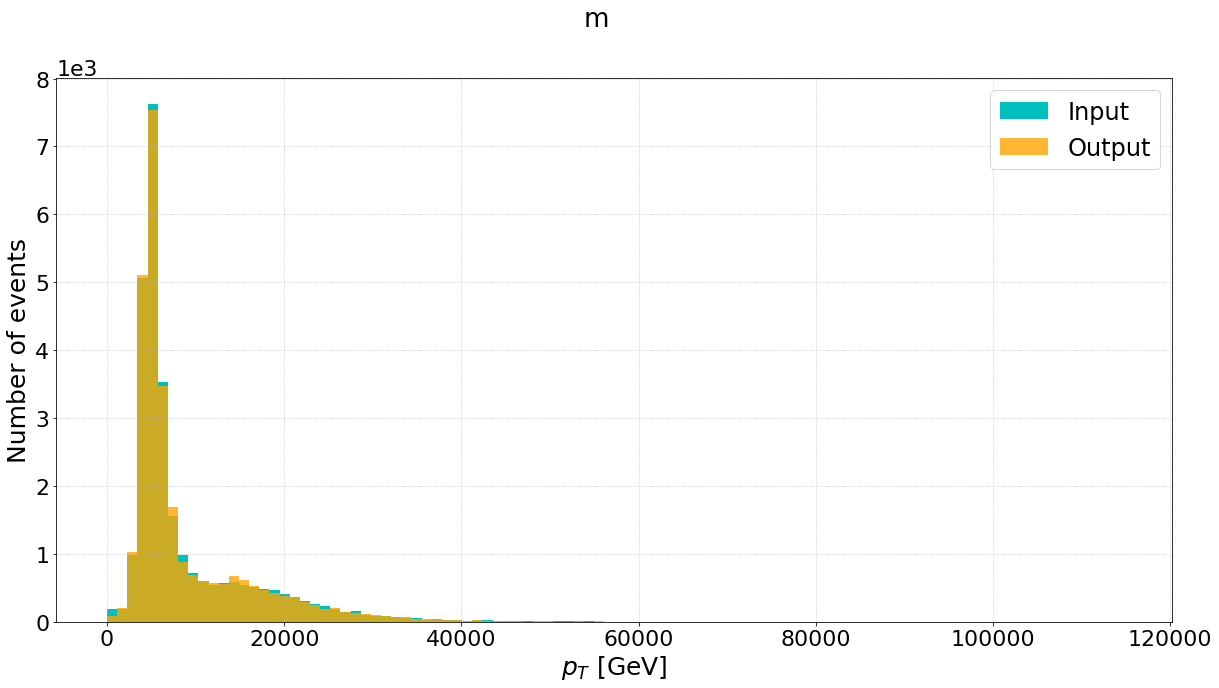

In [29]:
plt.figure(0 + 4,figsize=(20,10))
n_hist_data, bin_edges, _ = plt.hist(data[:, 0], color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(pred[:, 0], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
plt.suptitle(train_x.columns[0])
plt.xlabel(variable_list[0] + ' ' + unit_list[0])
plt.ylabel('Number of events')
ms.sciy()
# plt.yscale('log')
plt.legend()
fig_name = 'trainforever_hist_%s' % train.columns[0]
#plt.savefig(curr_save_folder + fig_name)

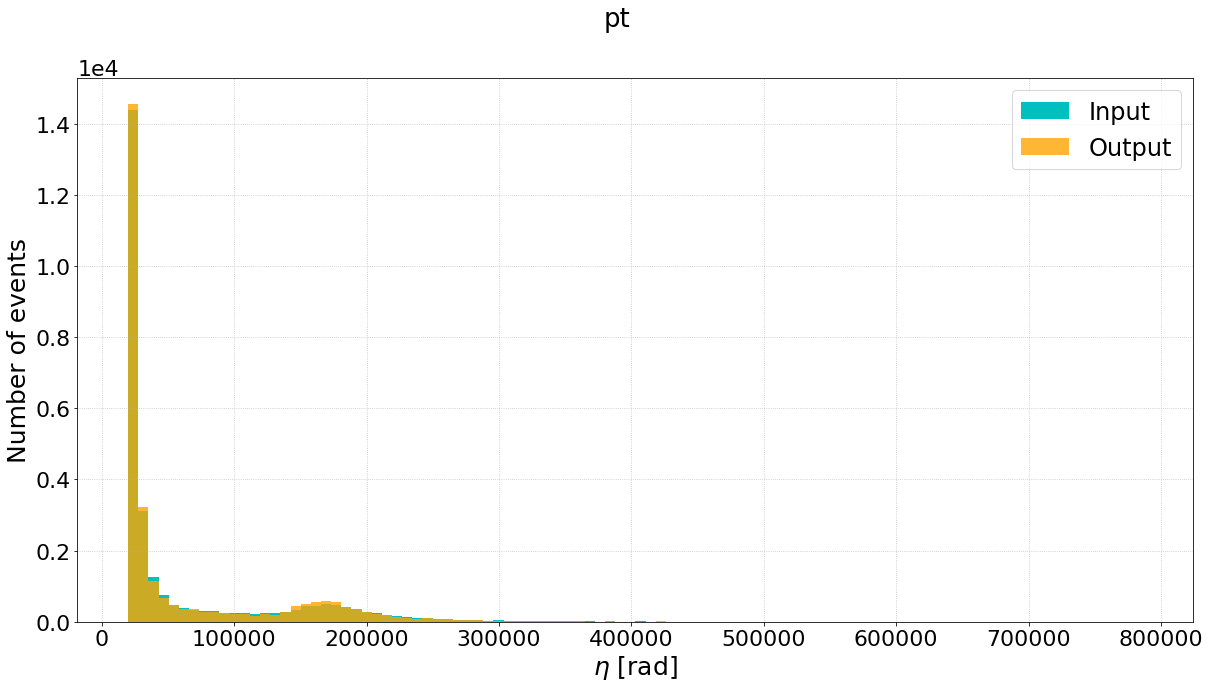

In [28]:
plt.figure(1 + 4,figsize=(20,10))
n_hist_data, bin_edges, _ = plt.hist(data[:, 1], color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(pred[:, 1], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
plt.suptitle(train_x.columns[1])
plt.xlabel(variable_list[1] + ' ' + unit_list[1])
plt.ylabel('Number of events')
ms.sciy()
# plt.yscale('log')
plt.legend()
fig_name = 'trainforever_hist_%s' % train.columns[1]
#plt.savefig(curr_save_folder + fig_name)

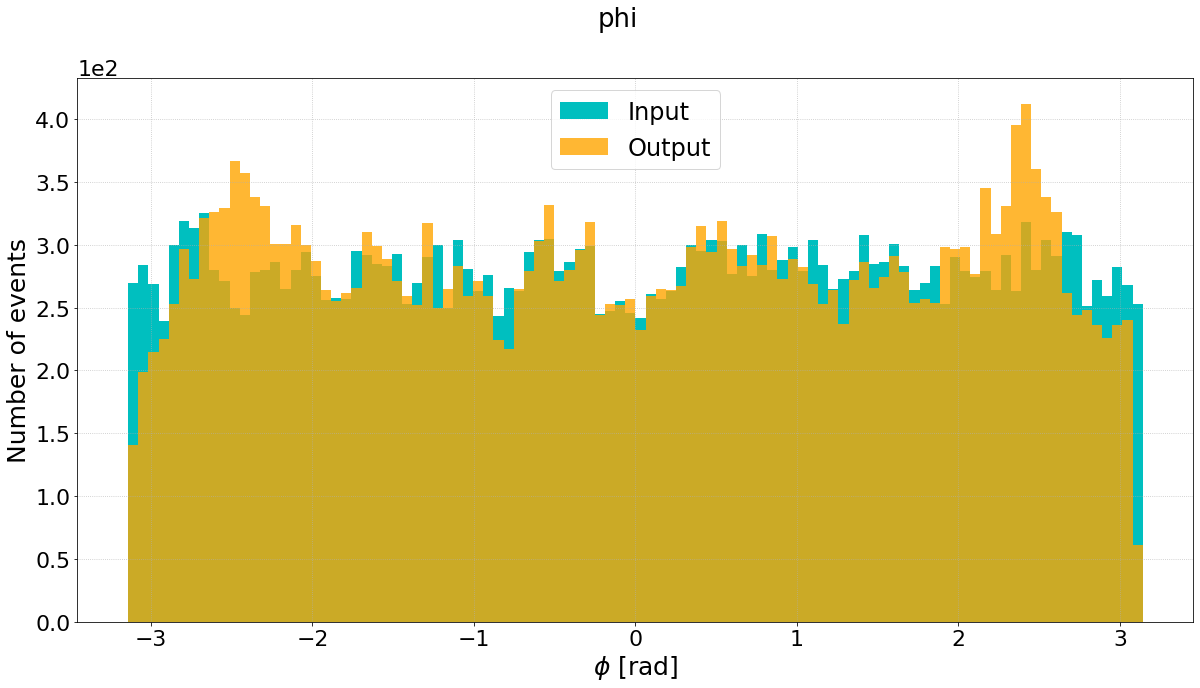

In [26]:
plt.figure(2 + 4,figsize=(20,10))
n_hist_data, bin_edges, _ = plt.hist(data[:, 2], color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(pred[:, 2], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
plt.suptitle(train_x.columns[2])
plt.xlabel(variable_list[2] + ' ' + unit_list[2])
plt.ylabel('Number of events')
ms.sciy()
# plt.yscale('log')
plt.legend()
fig_name = 'trainforever_hist_%s' % train.columns[2]
#plt.savefig(curr_save_folder + fig_name)

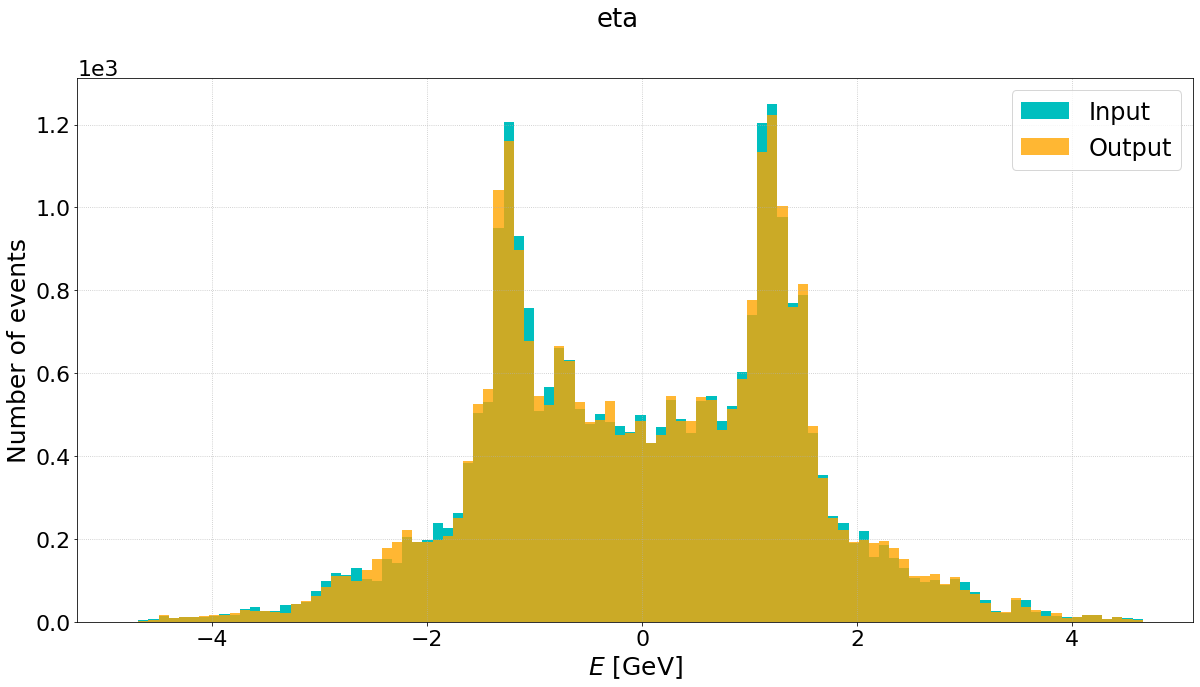

In [27]:
plt.figure(2 + 4,figsize=(20,10))
n_hist_data, bin_edges, _ = plt.hist(data[:, 3], color=colors[1], label='Input', alpha=1, bins=n_bins)
n_hist_pred, _, _ = plt.hist(pred[:, 3], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
plt.suptitle(train_x.columns[3])
plt.xlabel(variable_list[3] + ' ' + unit_list[3])
plt.ylabel('Number of events')
ms.sciy()
# plt.yscale('log')
plt.legend()
fig_name = 'trainforever_hist_%s' % train.columns[3]
#plt.savefig(curr_save_folder + fig_name)

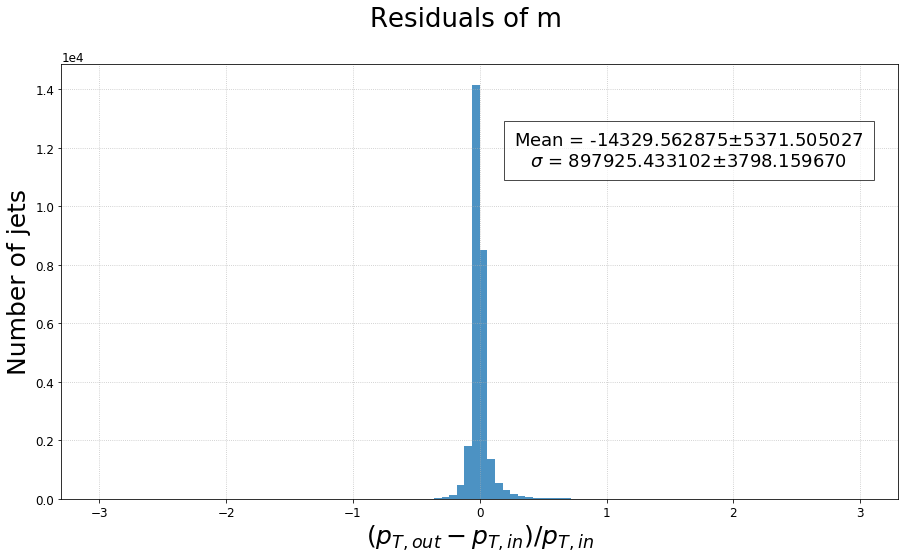

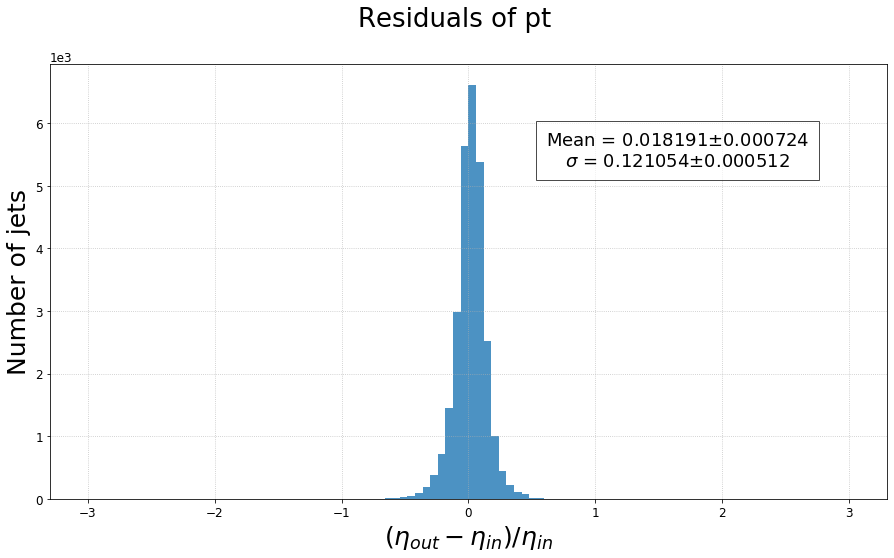

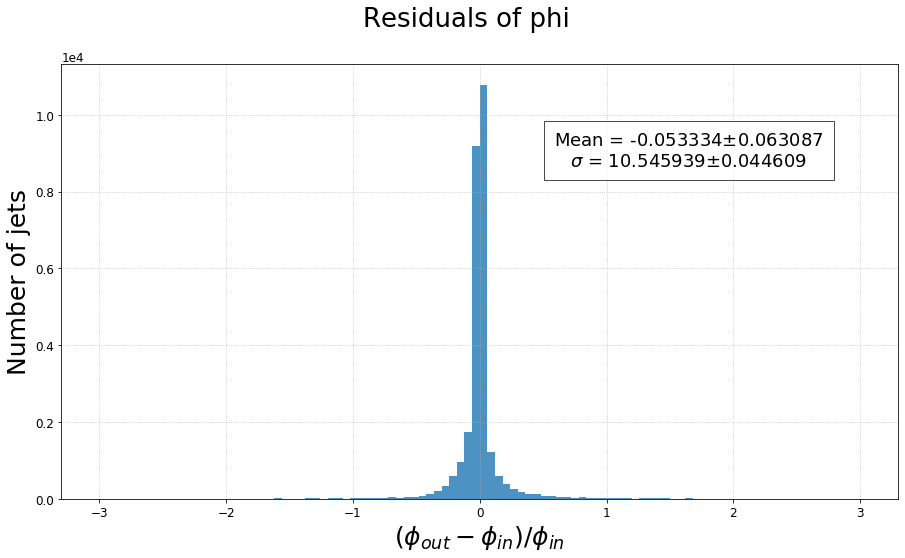

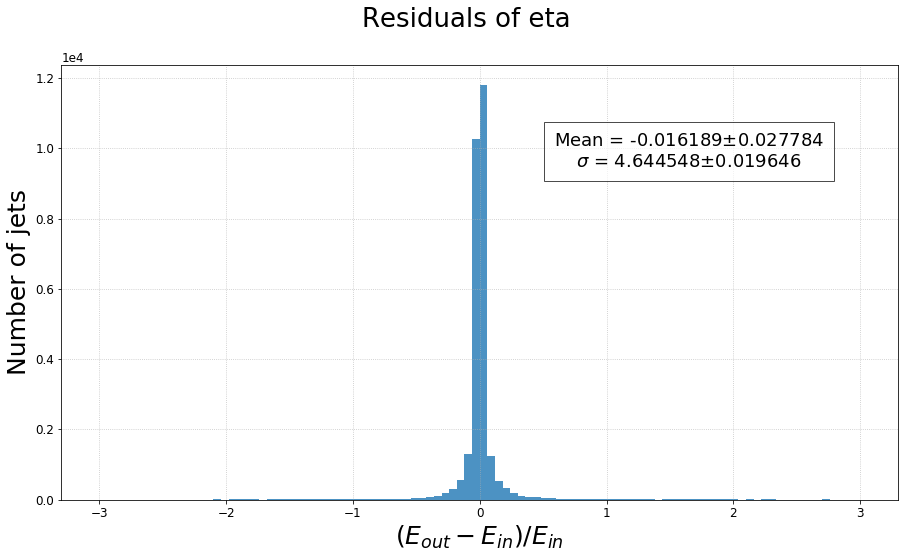

In [35]:
import utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-3, 3)
#range=None
for kk in np.arange(4):
    plt.figure(figsize=(15,8))
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

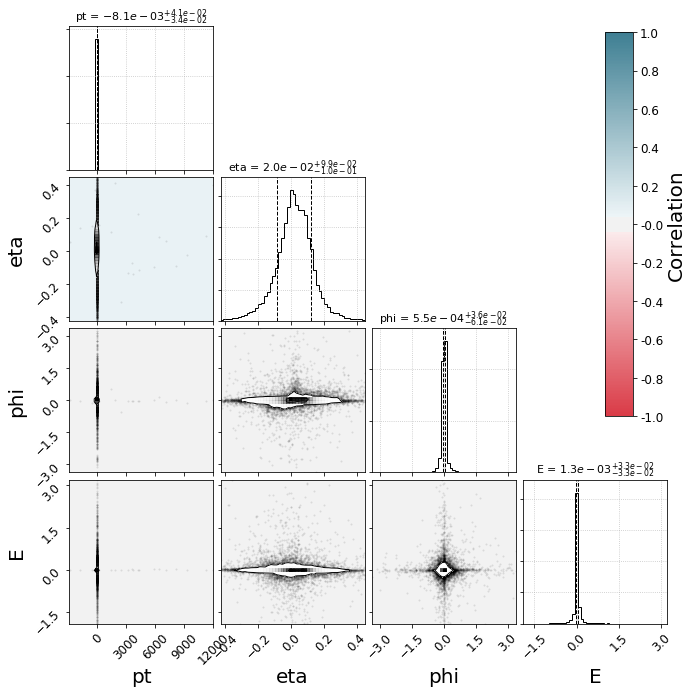

In [31]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)